In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
import math

# Get the Data

In [61]:
maneuvers = pd.read_csv("maneuvers.csv")
#maneuvers.head()

In [62]:
maneuvers.describe()

,t,x,y,z,dx,dy,dz,dv_st
count,2051.000000,2.051000e+03,2051.0,2.051000e+03,2.051000e+03,2.051000e+03,2.051000e+03,2.051000e+03
mean,3144.884936,-9.916647e-01,0.0,8.983646e-04,-6.235788e-12,9.931021e-03,-1.151716e-10,1.867347e-11
std,1811.726054,1.174921e-09,0.0,5.892229e-09,3.999124e-12,4.014230e-09,7.589918e-11,1.740525e-12
min,9.177680,-9.916647e-01,0.0,8.983543e-04,-1.485260e-11,9.931014e-03,-2.453321e-10,1.289239e-11
25%,1577.031312,-9.916647e-01,0.0,8.983596e-04,-9.841168e-12,9.931018e-03,-1.891698e-10,1.749108e-11
50%,3144.884939,-9.916647e-01,0.0,8.983647e-04,-6.062617e-12,9.931021e-03,-1.154269e-10,1.868876e-11
75%,4712.738561,-9.916647e-01,0.0,8.983697e-04,-2.750196e-12,9.931024e-03,-4.150443e-11,1.990991e-11
max,6280.592177,-9.916647e-01,0.0,8.983748e-04,3.372850e-12,9.931028e-03,1.607409e-11,2.437131e-11


Notice that dv_vel varies in the range -2e-7 to 1e-7, while dv_st varies in the range -7e-9 to 4e-9, so the MOST COSTLY maneuvers are much larger using CORRECTION_VEL method than using CORRECTION_ST !!

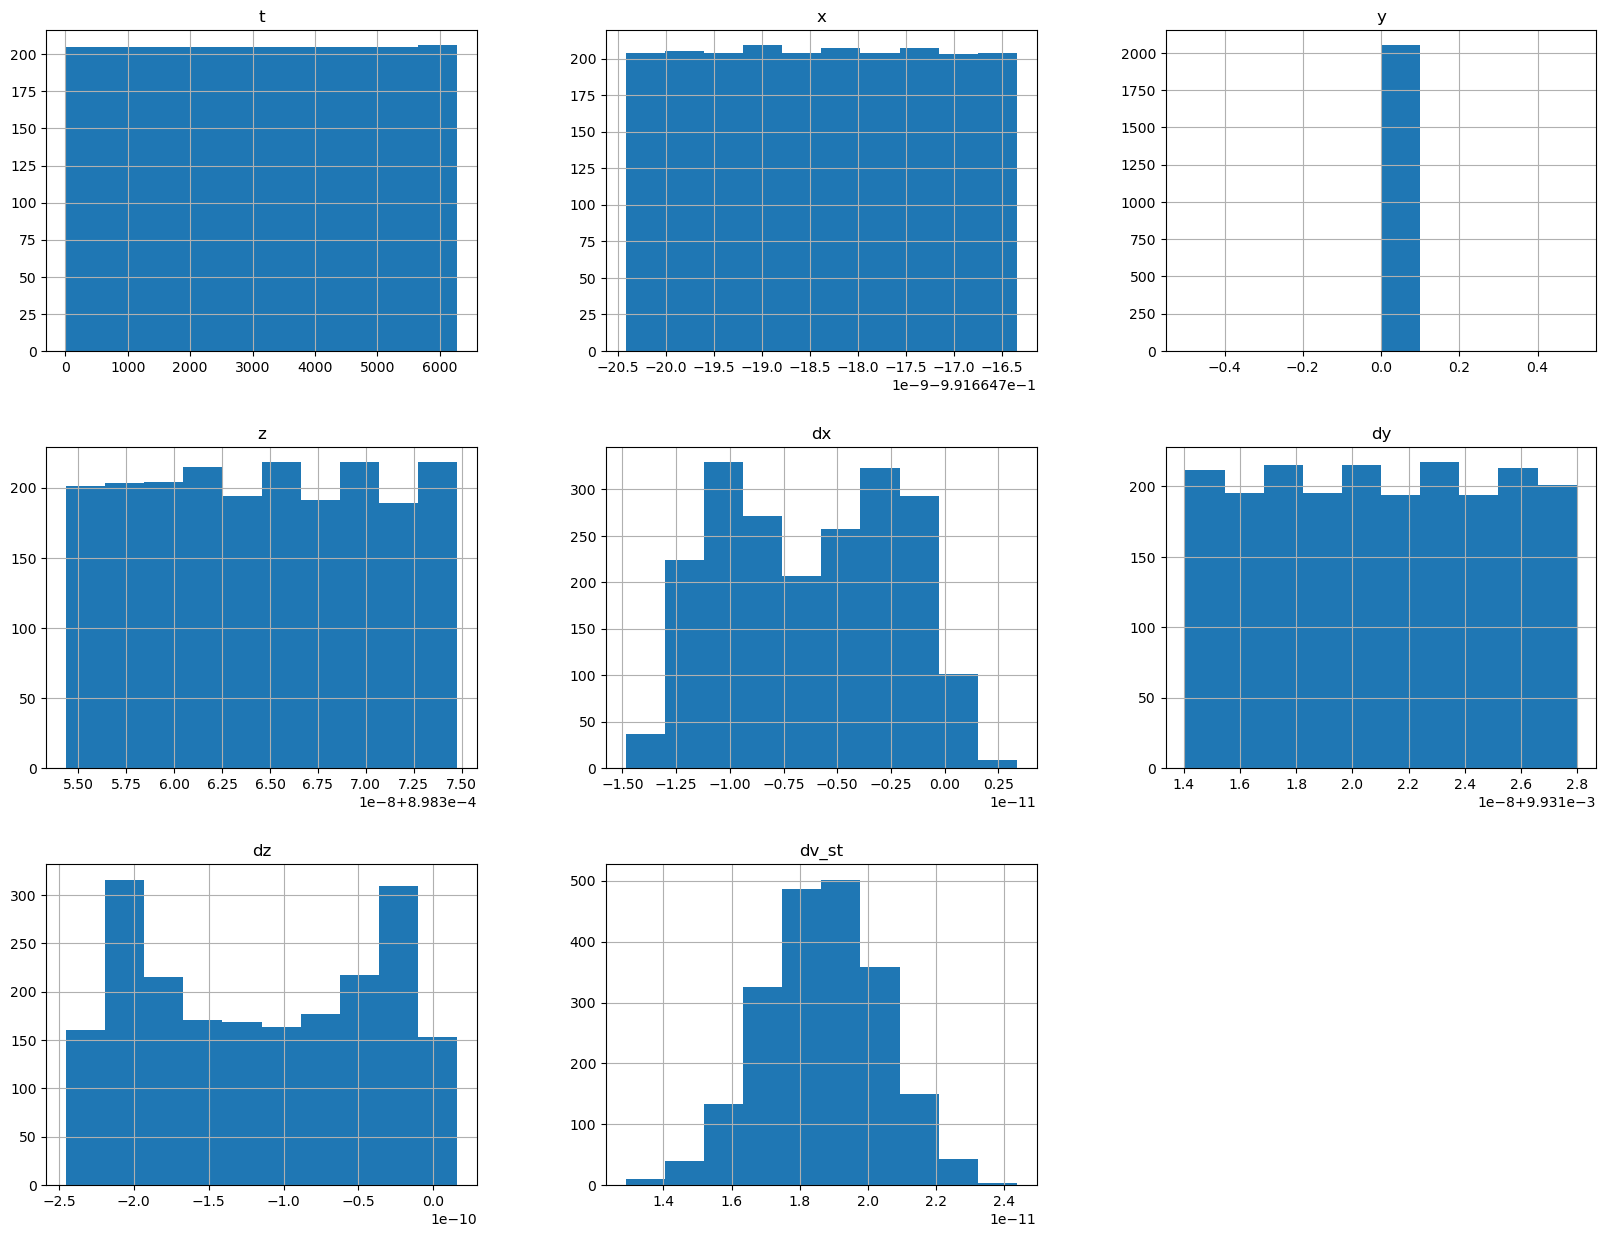

In [63]:
maneuvers.hist(figsize=(20,15))
plt.show()

Histograms of attributes (x,y,z,dx,dy,dz) are tail heavy. We may need to transform to polar coords, or use angle in p.o. as extra attribute.

## Visualizing Data

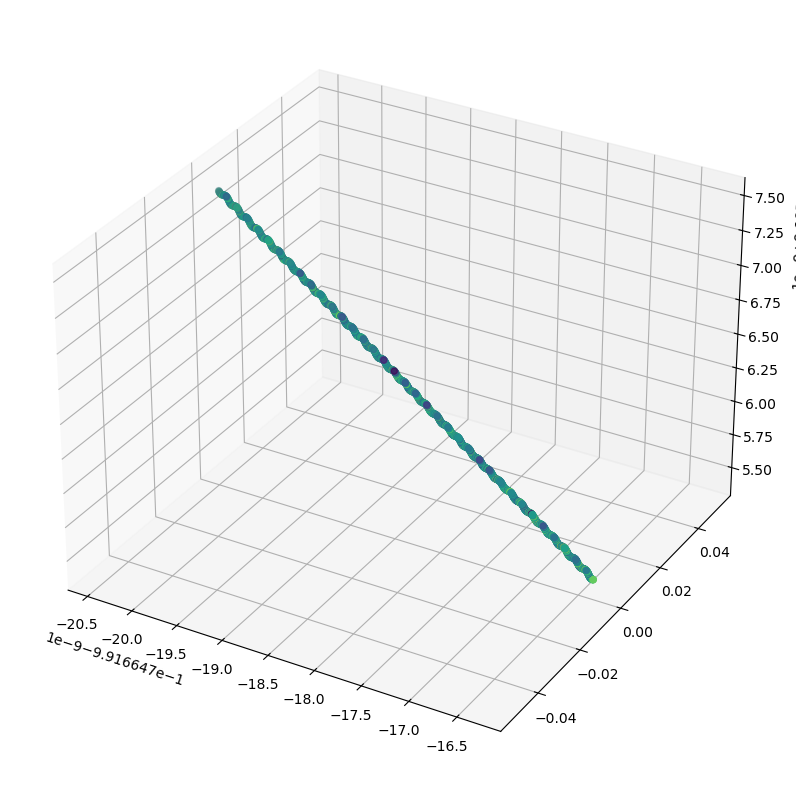

In [64]:
# Visualize shadowing orbit in position space, i.e. the points where correction
# maneuvers are performed.

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(maneuvers['x'], maneuvers['y'], maneuvers['z'], c=maneuvers['dv_st'])
plt.show()

Try adding new attribute "angle" = angle in the periodic orbit, which is essentially time/period.

In [65]:
#maneuvers["angle"]=maneuvers["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers = maneuvers.drop(["t"], axis=1)
maneuvers = maneuvers.drop(["y"], axis=1)
corr_matrix = maneuvers.corr()
corr_matrix["dv_st"].sort_values(ascending=False)

dv_st    1.000000
x        0.023521
dz       0.004749
dy      -0.023640
z       -0.023851
dx      -0.285335
Name: dv_st, dtype: float64

array([[<Axes: xlabel='x', ylabel='x'>, <Axes: xlabel='z', ylabel='x'>,
        <Axes: xlabel='dx', ylabel='x'>, <Axes: xlabel='dy', ylabel='x'>,
        <Axes: xlabel='dz', ylabel='x'>,
        <Axes: xlabel='dv_st', ylabel='x'>],
       [<Axes: xlabel='x', ylabel='z'>, <Axes: xlabel='z', ylabel='z'>,
        <Axes: xlabel='dx', ylabel='z'>, <Axes: xlabel='dy', ylabel='z'>,
        <Axes: xlabel='dz', ylabel='z'>,
        <Axes: xlabel='dv_st', ylabel='z'>],
       [<Axes: xlabel='x', ylabel='dx'>, <Axes: xlabel='z', ylabel='dx'>,
        <Axes: xlabel='dx', ylabel='dx'>,
        <Axes: xlabel='dy', ylabel='dx'>,
        <Axes: xlabel='dz', ylabel='dx'>,
        <Axes: xlabel='dv_st', ylabel='dx'>],
       [<Axes: xlabel='x', ylabel='dy'>, <Axes: xlabel='z', ylabel='dy'>,
        <Axes: xlabel='dx', ylabel='dy'>,
        <Axes: xlabel='dy', ylabel='dy'>,
        <Axes: xlabel='dz', ylabel='dy'>,
        <Axes: xlabel='dv_st', ylabel='dy'>],
       [<Axes: xlabel='x', ylabel='dz'>, <Ax

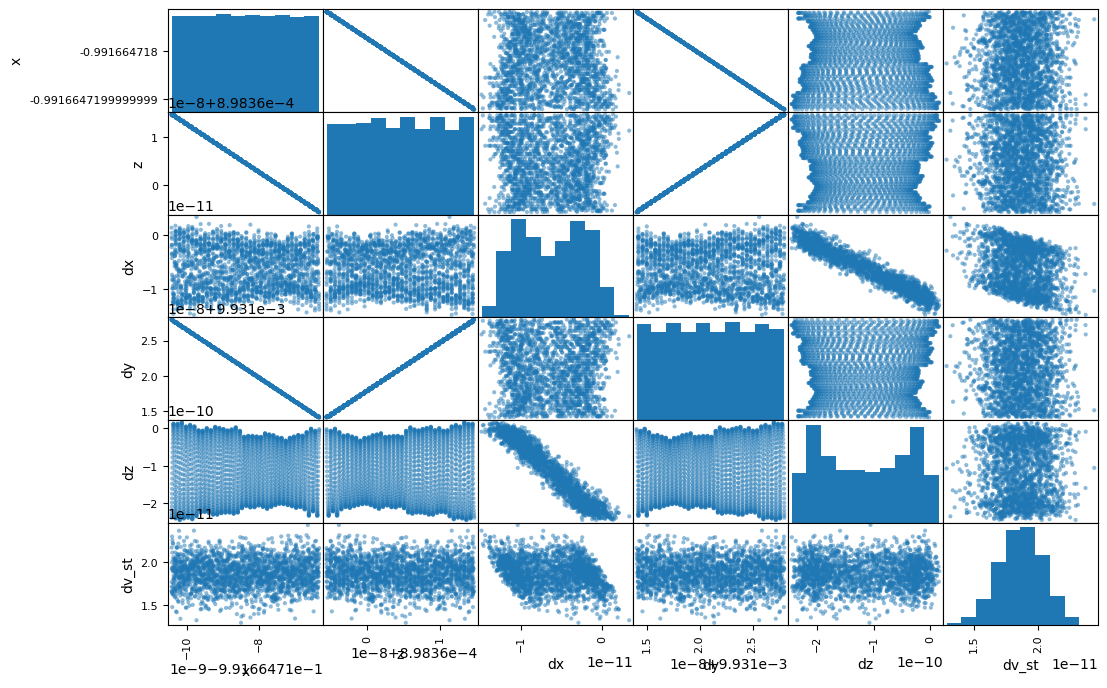

In [66]:
#attributes = ["angle", "x", "dx", "dv_st"]
attributes = ["x", "z", "dx", "dy", "dz", "dv_st"]
scatter_matrix(maneuvers[attributes], figsize=(12, 8))

dv_st is either positively or negatively correlated to state variables (x,y,z,dx,dy,dz) !!

Notice that angle and dv_st are not correlated, but they are nonlinearly related ("V" shape) !!

y, dx and dz are perfectly correlated!!!

# Prepare the Data for Machine Learning Algorithms

## Create a Train/Test Set

In [67]:
# Let's separate the predictors and the labels

# Drop dx and dz features, since they are almost proportional to y
#maneuvers_predictors = maneuvers.drop(["dx", "dz", "dv_st"], axis=1)

maneuvers_predictors = maneuvers.drop("dv_st", axis=1)
maneuvers_labels = maneuvers[["dv_st"]].copy()
maneuvers_predictors.head()
#maneuvers_labels.head()

,x,z,dx,dy,dz
0,-0.991665,0.000898,-1.387705e-11,0.009931,-2.061542e-12
1,-0.991665,0.000898,-1.326854e-11,0.009931,-5.491069e-12
2,-0.991665,0.000898,-1.271020e-11,0.009931,-1.039892e-11
3,-0.991665,0.000898,-1.193514e-11,0.009931,-1.669678e-11
4,-0.991665,0.000898,-1.087814e-11,0.009931,-2.426845e-11


## Create Train/Test/Validation Sets

In [68]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
maneuvers_predictors, maneuvers_labels, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
X_train.head()

(1230, 5)
(411, 5)
(410, 5)


,x,z,dx,dy,dz
59,-0.991665,0.000898,-1.023646e-11,0.009931,-1.664104e-11
871,-0.991665,0.000898,-8.752328e-12,0.009931,-2.946211e-11
1411,-0.991665,0.000898,-9.880522e-13,0.009931,-2.082503e-10
1680,-0.991665,0.000898,-1.269605e-11,0.009931,-6.827348e-12
1257,-0.991665,0.000898,-2.924468e-12,0.009931,-1.483747e-10


In [69]:
# Scale all the features. This transforms data type from dataframe to numpy array.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:5]

array([[0.97044274, 0.028747  , 0.26641475, 0.03028757, 0.88363099],
       [0.57457662, 0.4253629 , 0.35501695, 0.42565656, 0.83409214],
       [0.31192315, 0.68670362, 0.81854108, 0.68893982, 0.14327896],
       [0.18144187, 0.81935473, 0.11957829, 0.8179251 , 0.92154975],
       [0.38797128, 0.61884961, 0.70293785, 0.60796986, 0.3746303 ]])

In [70]:
# Try PCA of data
from sklearn.decomposition import PCA
pca_pred = PCA(n_components=2, whiten=True)   # PCA of predictors
principalComponents_pred = pca_pred.fit_transform(X_train_scaled)
print('Explained variability per principal component: {}'.format(pca_pred.explained_variance_ratio_))

# X_train_scaled = pca_pred.transform(X_train_scaled)
# X_valid_scaled = pca_pred.transform(X_valid_scaled)
# X_test_scaled = pca_pred.transform(X_test_scaled)
# X_train_scaled[:5]

Explained variability per principal component: [0.63505716 0.35811629]


In [71]:
# Scale target variable dv_st as well.
# Rationale: dv_st takes very small values (10^{-8}), 
# so MSE may be tiny and not computed properly. Also, NN may converge faster?

scaler_target = MinMaxScaler()
y_train_scaled = scaler_target.fit_transform(y_train)
y_valid_scaled = scaler_target.transform(y_valid)
y_test_scaled = scaler_target.transform(y_test)

<Figure size 640x480 with 0 Axes>

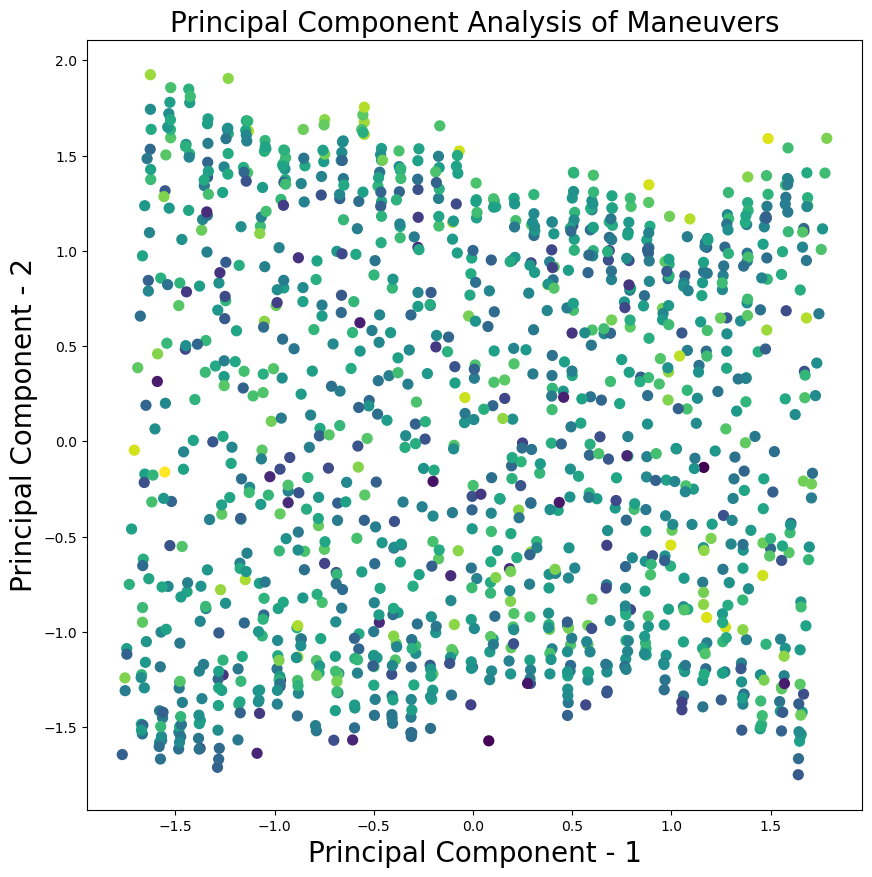

In [72]:
# Plot results of PCA
plt.figure()
plt.figure(figsize=(10,10))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Maneuvers",fontsize=20)
plt.scatter(principalComponents_pred[:, 0], principalComponents_pred[:, 1], c=y_train_scaled, s = 50)

From the above picture, it is seems that (PC1, PC2) only do not allow to distinguish dv. 

In [73]:
import joblib
joblib.dump(scaler, 'scaler_supervised.gz')
joblib.dump(scaler_target, 'scaler_target_supervised.gz')

['scaler_target_supervised.gz']

# Select and Train a Model

## Training and Evaluating on the Training Set

In [74]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [75]:
# Let's measure this regression model's RMSE on the whole training set
from sklearn.metrics import mean_squared_error
maneuvers_predictions = lin_reg.predict(X_train_scaled)
lin_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.00010647604329379024

In [76]:
# Let’s train a DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_scaled, y_train_scaled)

maneuvers_predictions = tree_reg.predict(X_train_scaled)
tree_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

NOW THIS IS MUCH BETTER!!

In [77]:
#Let's try it out on 5 instances from the test set
some_data = X_test_scaled[10:20]
some_labels = y_test_scaled[10:20]
print("Predictions:", list(tree_reg.predict(some_data)))
print("Labels:", list(some_labels))

Predictions: [0.7424908226188538, 0.4572777084576576, 0.3836416571728243, 0.5779670518454221, 0.7848604857230692, 0.6490352447603029, 0.7437205012748878, 0.24799725130653383, 0.4128284417439736, 0.2382502396065025]
Labels: [array([0.85193222]), array([0.50800195]), array([0.34326118]), array([0.60042677]), array([0.75270801]), array([0.65746216]), array([0.71721008]), array([0.16410785]), array([0.44212373]), array([0.2991555])]


In [78]:
# Let’s train a RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_scaled, y_train_scaled)

maneuvers_predictions = forest_reg.predict(X_train_scaled)
forest_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.010286154411521337

## Polynomial Regression

In [79]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
maneuvers_pred_poly = poly_features.fit_transform(X_train_scaled)
#print(X_train_scaled.head())
print(maneuvers_pred_poly[0])
#poly_features.get_feature_names_out(['x','y','z','dy'])

[9.70442742e-01 2.87469994e-02 2.66414752e-01 3.02875730e-02
 8.83630993e-01 9.41759116e-01 2.78973170e-02 2.58540263e-01
 2.93923554e-02 8.57513284e-01 8.26389977e-04 7.65862473e-03
 8.70676844e-04 2.54017397e-02 7.09768202e-02 8.06905625e-03
 2.35412332e-01 9.17337078e-04 2.67630382e-02 7.80803731e-01]


In [80]:
my_lin_reg = LinearRegression()
my_lin_reg.fit(maneuvers_pred_poly, y_train_scaled)
print(my_lin_reg.coef_)
maneuvers_predictions = my_lin_reg.predict(maneuvers_pred_poly)
lin_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

[[-1.63823780e+07 -6.23491850e+06  1.40975281e+04 -1.01502170e+07
   1.09912055e+04  8.19606048e+06  6.23862659e+06 -1.41084357e+04
   1.01562535e+07 -1.09997106e+04  1.18717000e+06 -5.36948269e+03
   3.86533667e+06 -4.18634516e+03  6.07154629e+00 -8.74132782e+03
   9.46742755e+00  3.14631318e+06 -6.81521696e+03  3.69074866e+00]]


4.59411355679284e-05

## SVM Regression

In [81]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2)
svm_poly_reg.fit(X_train_scaled, y_train_scaled)
maneuvers_predictions = svm_poly_reg.predict(X_train_scaled)
svm_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.039542552879085466

## Cross-validation

Scikit-Learn’s K-fold cross-validation feature. The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Random Forest model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores.

In [82]:
from sklearn.model_selection import cross_val_score
#tree_reg = DecisionTreeRegressor()
#forest_reg = RandomForestRegressor()
lin_reg = LinearRegression()
scores = cross_val_score(lin_reg, maneuvers_pred_poly, y_train_scaled,
scoring="neg_root_mean_squared_error", cv=5)
poly_rmse_scores = -scores

In [83]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(poly_rmse_scores)

Scores: [4.54889951e-05 4.74321116e-05 4.38108960e-05 4.73044177e-05
 4.96224041e-05]
Mean: 4.6731764897949914e-05
Standard deviation: 1.9621500008434796e-06


## Evaluate Model on Test Set

In [84]:
maneuvers_pred_poly = poly_features.fit_transform(X_test_scaled)
maneuvers_predictions = my_lin_reg.predict(maneuvers_pred_poly)
lin_mse = mean_squared_error(y_test_scaled, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

4.8801845490633786e-05

## Persist model

In [85]:
# Persist the model for future use (see correction_module.py) without having to retrain.
# Here you can replace pickle with joblib or cloudpickle
from pickle import dump
with open("model_supervised.pkl", "wb") as f:
    dump(my_lin_reg, f, protocol=5)